# Sentiment Analysis

Now, we have our cleaned dataset. We can start do our sentiment analysis on the comments about ```VOO``` from Subreddit ```r/ETFs```.

## Import Libraries

In [190]:
import pandas as pd

import torch

## Import the datasets

In [191]:
df = pd.read_csv('../datasets/cleaned_cmts_voo.csv')
df.head()

,author,id,date,permalink,body,score,subreddit
0,investing_me,kwsc2e7,2024-03-27,/r/ETFs/comments/1boyqg6/375qqq125tqqq375voo12...,Just buy VOO at this point,6,ETFs
1,iamfredrick,kwv4b7y,2024-03-27,/r/ETFs/comments/1bpdnmd/schg_schd_vs_voo/kwv4...,Voo & schg have 53% overlap. Past results don’...,3,ETFs
2,Fun_Grapefruit_3416,kwvj6cq,2024-03-27,/r/ETFs/comments/1bpdnmd/schg_schd_vs_voo/kwvj...,Schd + Schg makes up the majority of voo. Just...,2,ETFs
3,rem14,kwvnzn8,2024-03-27,/r/ETFs/comments/1bpdnmd/schg_schd_vs_voo/kwvn...,13% overlap with VOO and less than 1% overlap ...,2,ETFs
4,Strong_Ask1808,kwzy9g2,2024-03-28,/r/ETFs/comments/1bq2hk5/voo_vgt_vti/kwzy9g2/,"Majority of VGT is in VOO, so there’s a lot of...",8,ETFs


## Using Transformer Model in Sentiment Analysis

### Example
An example to show the model works.

In [192]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [193]:
sentence_pos = "Stock price of VOO will go higher"
sentence_neg = "Never ever buy VOO"

In [194]:
classifier(sentence_pos), classifier(sentence_neg)

([{'label': 'POSITIVE', 'score': 0.5957298278808594}],
 [{'label': 'NEGATIVE', 'score': 0.9967347979545593}])

In [195]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
pt_model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [196]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [197]:
inputs_pos, inputs_neg = tokenizer(sentence_pos), tokenizer(sentence_neg)

In [198]:
inputs_pos, inputs_neg

({'input_ids': [101, 4518, 3976, 1997, 29536, 2080, 2097, 2175, 3020, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'input_ids': [101, 2196, 2412, 4965, 29536, 2080, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]})

In [199]:
tokenizer.convert_ids_to_tokens([29536, 2080])

['vo', '##o']

In [200]:
pt_batch = tokenizer(
    [sentence_pos, sentence_neg], 
    padding=True, 
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

In [201]:
pt_batch

{'input_ids': tensor([[  101,  4518,  3976,  1997, 29536,  2080,  2097,  2175,  3020,   102],
        [  101,  2196,  2412,  4965, 29536,  2080,   102,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])}

In [202]:
pt_outputs = pt_model(**pt_batch)

pt_outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-0.1119,  0.2758],
        [ 3.1458, -2.5754]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [203]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = 'distilbert-base-uncased-finetuned-sst-2-english'

pt_model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

def get_label_and_score(output):
    # Apply softmax to output logits
    probabilities = torch.nn.functional.softmax(output.logits, dim=-1)

    # Get the predicted label (0 or 1) based on the highest probability
    label = torch.argmax(probabilities, dim=-1).item()

    # Get the probability score for the predicted label
    score = probabilities[0][label].item()

    return label, score

results = []

for comment in df['body']:
    pt_batch = tokenizer(
        str(comment), 
        padding=True, 
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    pt_outputs = pt_model(**pt_batch)
    label, score = get_label_and_score(pt_outputs)
    results.append((label, score))

labels, scores = zip(*results)
df['sentiment_label'] = labels
df['sentiment_score'] = scores


In [204]:
df.head()

,author,id,date,permalink,body,score,subreddit,sentiment_label,sentiment_score
0,investing_me,kwsc2e7,2024-03-27,/r/ETFs/comments/1boyqg6/375qqq125tqqq375voo12...,Just buy VOO at this point,6,ETFs,1,0.513832
1,iamfredrick,kwv4b7y,2024-03-27,/r/ETFs/comments/1bpdnmd/schg_schd_vs_voo/kwv4...,Voo & schg have 53% overlap. Past results don’...,3,ETFs,1,0.990680
2,Fun_Grapefruit_3416,kwvj6cq,2024-03-27,/r/ETFs/comments/1bpdnmd/schg_schd_vs_voo/kwvj...,Schd + Schg makes up the majority of voo. Just...,2,ETFs,0,0.997663
3,rem14,kwvnzn8,2024-03-27,/r/ETFs/comments/1bpdnmd/schg_schd_vs_voo/kwvn...,13% overlap with VOO and less than 1% overlap ...,2,ETFs,0,0.995360
4,Strong_Ask1808,kwzy9g2,2024-03-28,/r/ETFs/comments/1bq2hk5/voo_vgt_vti/kwzy9g2/,"Majority of VGT is in VOO, so there’s a lot of...",8,ETFs,0,0.991675


In [205]:
sentiment_df = df[['date', 'body', 'sentiment_label', 'sentiment_score']]

sentiment_df.head()

,date,body,sentiment_label,sentiment_score
0,2024-03-27,Just buy VOO at this point,1,0.513832
1,2024-03-27,Voo & schg have 53% overlap. Past results don’...,1,0.990680
2,2024-03-27,Schd + Schg makes up the majority of voo. Just...,0,0.997663
3,2024-03-27,13% overlap with VOO and less than 1% overlap ...,0,0.995360
4,2024-03-28,"Majority of VGT is in VOO, so there’s a lot of...",0,0.991675


In [206]:
sentiment_df.isnull().sum()

date               0
body               0
sentiment_label    0
sentiment_score    0
dtype: int64

## Visualizing the Data

### Time Series of Sentiment Counts

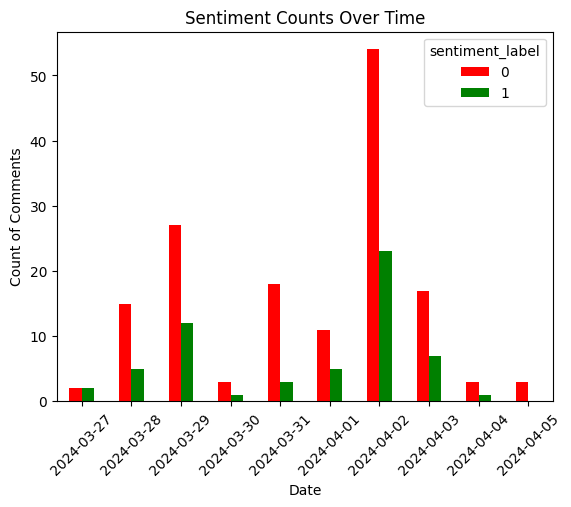

In [207]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'date': sentiment_df['date'],
    'sentiment_label': sentiment_df['sentiment_label'],
    'body': sentiment_df['body']
}

visualization_df = pd.DataFrame(data)

# Group by 'date' and 'sentiment_label', and count comments
grouped = visualization_df.groupby(['date', 'sentiment_label']).size().reset_index(name='count')

# Pivot the table
pivot_df = grouped.pivot(index='date', columns='sentiment_label', values='count').fillna(0)

# Plotting
pivot_df.plot(kind='bar', color=['red', 'green'])
plt.xlabel('Date')
plt.ylabel('Count of Comments')
plt.title('Sentiment Counts Over Time')
plt.xticks(rotation=45)
plt.show()

### Heatmap for Sentiment Count and Average Sentiment Intensity

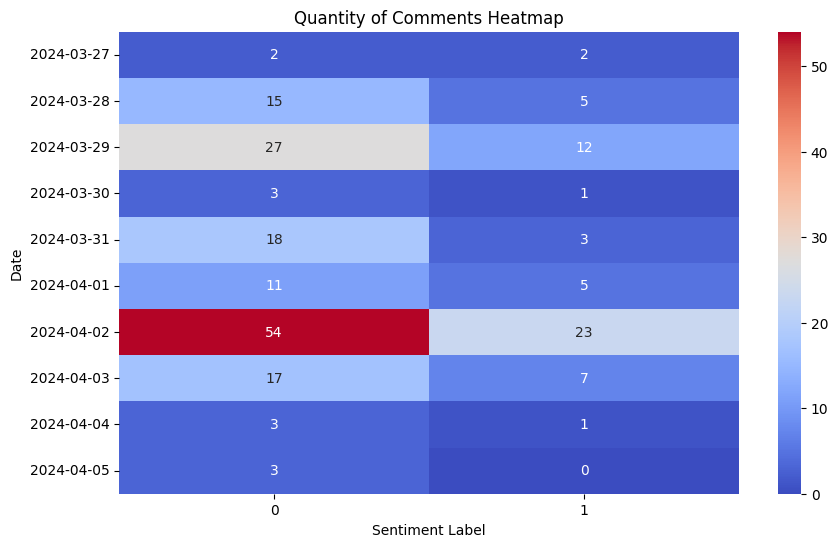

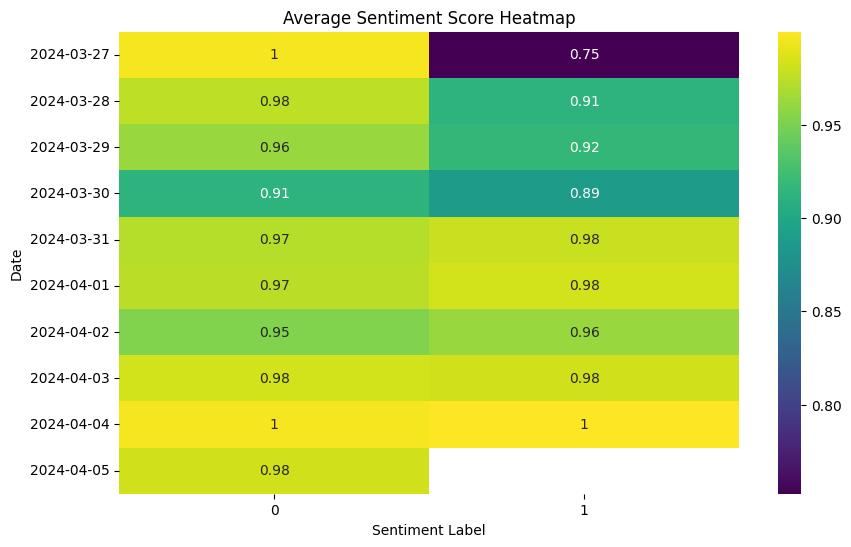

In [208]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data (replace this with your sentiment_df)
data = {
    'date': sentiment_df['date'],
    'sentiment_label': sentiment_df['sentiment_label'],
    'sentiment_score': sentiment_df['sentiment_score']
}

visualization_df = pd.DataFrame(data)

# Heatmap 1: Quantity of Comments
# Counting comments
count_df = visualization_df.groupby(['date', 'sentiment_label']).size().unstack(fill_value=0)

# Plotting heatmap for quantity
plt.figure(figsize=(10, 6))
sns.heatmap(count_df, annot=True, cmap='coolwarm')
plt.title('Quantity of Comments Heatmap')
plt.xlabel('Sentiment Label')
plt.ylabel('Date')
plt.show()

# Heatmap 2: Average Sentiment Intensity
# Calculating average sentiment score
# Group by 'date' and 'sentiment_label' and compute average sentiment score
grouped = visualization_df.groupby(['date', 'sentiment_label']).mean().reset_index()

# Pivot the table
pivot_df = grouped.pivot(index='date', columns='sentiment_label', values='sentiment_score')

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap='viridis')
plt.title('Average Sentiment Score Heatmap')
plt.xlabel('Sentiment Label')
plt.ylabel('Date')
plt.show()


### Stacked Bar Chart with Sentiment Scores

C:\Users\User\AppData\Local\Temp\ipykernel_14848\681731907.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_positive = positive_df.groupby(['date', 'score_bin']).size().unstack(fill_value=0)


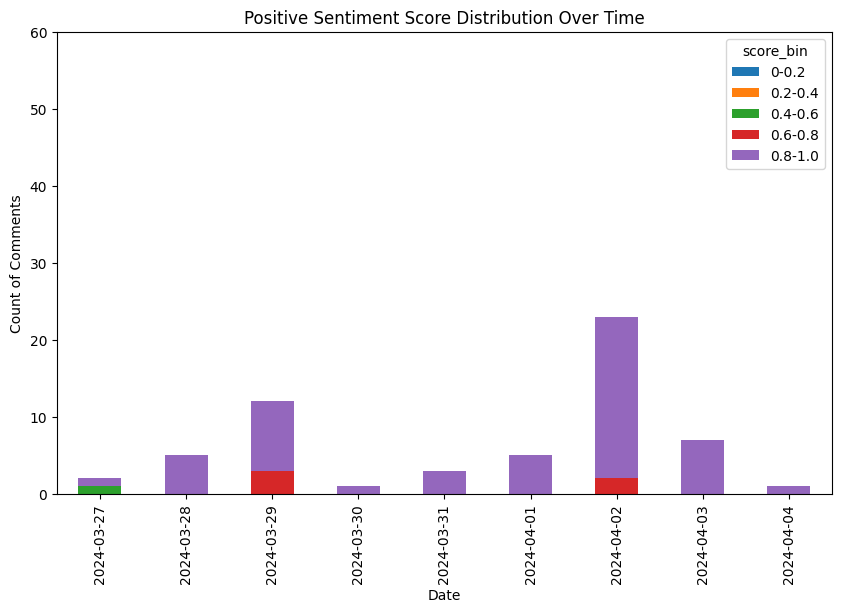

C:\Users\User\AppData\Local\Temp\ipykernel_14848\681731907.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_negative = negative_df.groupby(['date', 'score_bin']).size().unstack(fill_value=0)


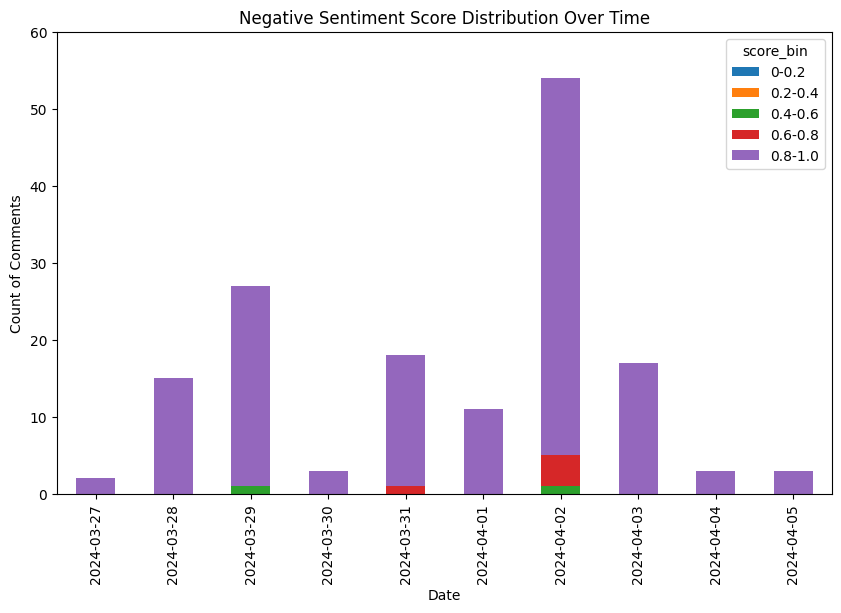

In [221]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (replace with your data)
data = {
    'date': sentiment_df['date'],
    'sentiment_score': sentiment_df['sentiment_score'],
    'sentiment_label': sentiment_df['sentiment_label']
}
visualization_df = pd.DataFrame(data)

# Bin the sentiment scores
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']
visualization_df['score_bin'] = pd.cut(visualization_df['sentiment_score'], bins=bins, labels=labels)

# Separate Positive and Negative DataFrames
positive_df = visualization_df[visualization_df['sentiment_label'] == 1]
negative_df = visualization_df[visualization_df['sentiment_label'] == 0]

# Plotting Stacked Bar Chart for Positive Sentiments
pivot_positive = positive_df.groupby(['date', 'score_bin']).size().unstack(fill_value=0)
pivot_positive.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Positive Sentiment Score Distribution Over Time')
plt.xlabel('Date')
plt.ylabel('Count of Comments')
plt.ylim(0, 60)
plt.show()

# Plotting Stacked Bar Chart for Negative Sentiments
pivot_negative = negative_df.groupby(['date', 'score_bin']).size().unstack(fill_value=0)
pivot_negative.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Negative Sentiment Score Distribution Over Time')
plt.xlabel('Date')
plt.ylabel('Count of Comments')
plt.ylim(0, 60)
plt.show()


### Cumulative Sentiment Score Over Time

C:\Users\User\AppData\Local\Temp\ipykernel_14848\882369499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df['cumulative_score'] = sentiment_df.groupby('date')['sentiment_score'].cumsum()


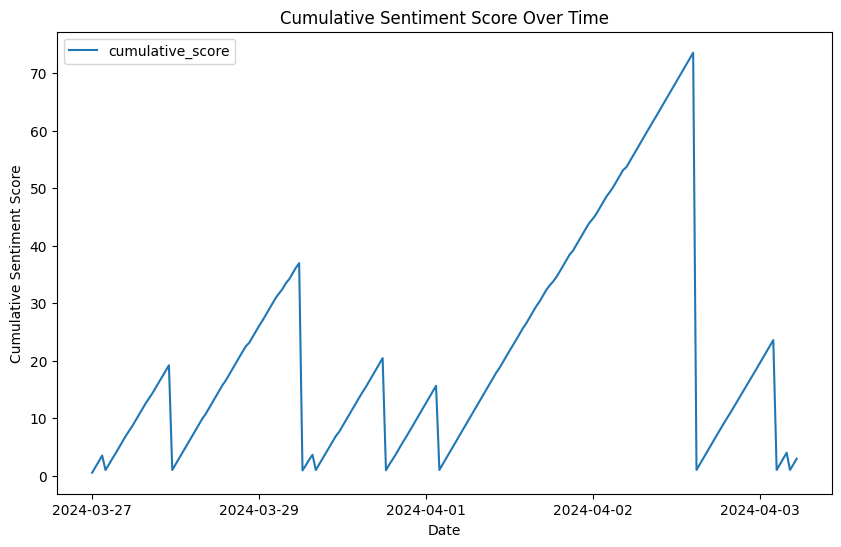

In [ ]:
# Assuming 'sentiment_score' is a continuous value between 0 and 1
sentiment_df['cumulative_score'] = sentiment_df.groupby('date')['sentiment_score'].cumsum()

# Plot
sentiment_df.plot(x='date', y='cumulative_score', kind='line', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Cumulative Sentiment Score')
plt.title('Cumulative Sentiment Score Over Time')
plt.show()


### Scatter Plot

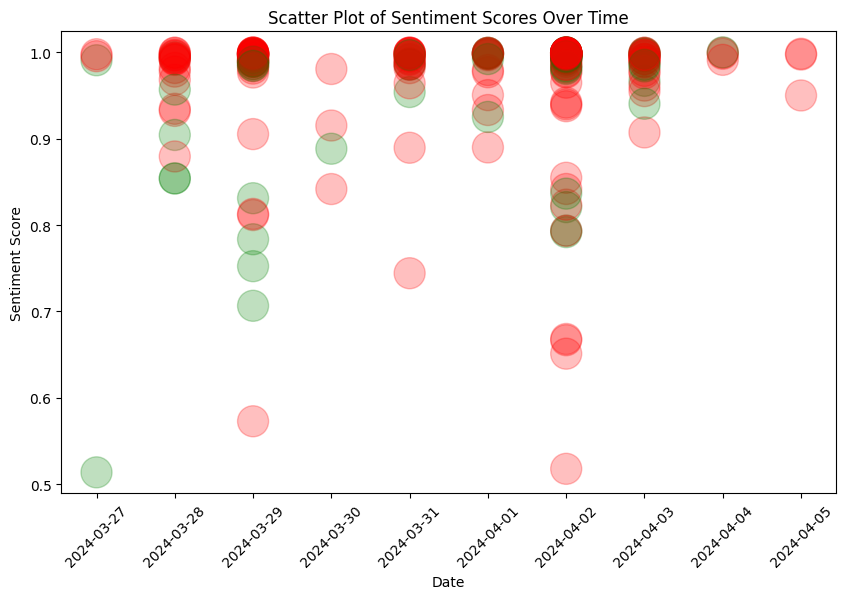

In [222]:
# Using different colors for different sentiment labels
colors = {0: 'red', 1: 'green'}

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(sentiment_df['date'], sentiment_df['sentiment_score'], c=sentiment_df['sentiment_label'].map(colors), s=500, alpha=0.25)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Scatter Plot of Sentiment Scores Over Time')
plt.xticks(rotation=45)
plt.show()


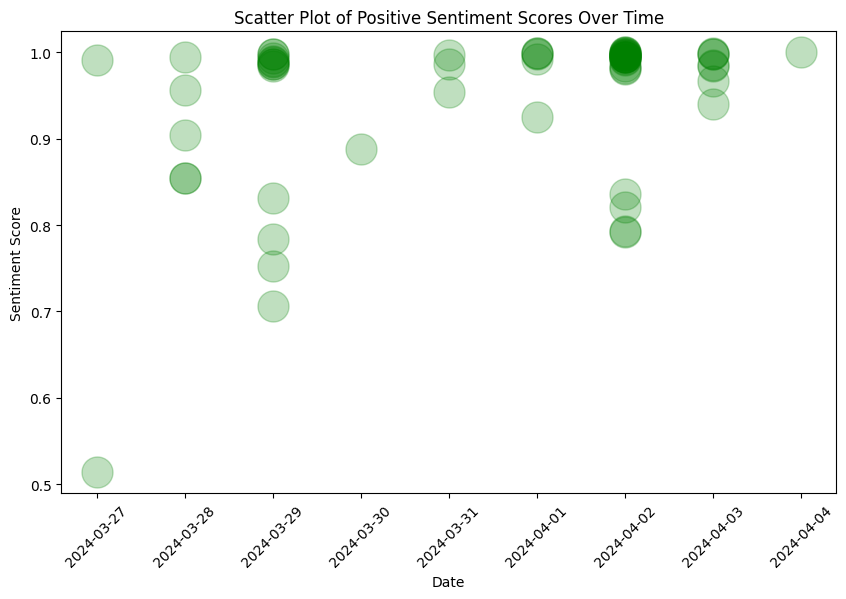

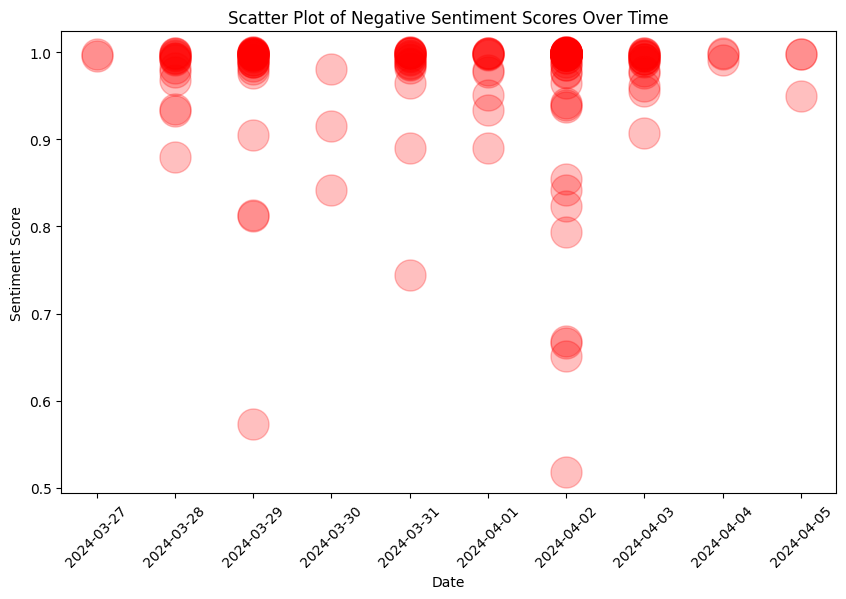

In [223]:
# Sample DataFrame
data = {
    'date': sentiment_df['date'],
    'sentiment_score': sentiment_df['sentiment_score'],
    'sentiment_label': sentiment_df['sentiment_label']
}
visualization_df = pd.DataFrame(data)

# Separating positive and negative comments
positive_df = visualization_df[visualization_df['sentiment_label'] == 1]
negative_df = visualization_df[visualization_df['sentiment_label'] == 0]

# Plot for Positive Comments
plt.figure(figsize=(10, 6))
plt.scatter(positive_df['date'], positive_df['sentiment_score'], color='green', s=500, alpha=0.25)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Scatter Plot of Positive Sentiment Scores Over Time')
plt.xticks(rotation=45)
plt.show()

# Plot for Negative Comments
plt.figure(figsize=(10, 6))
plt.scatter(negative_df['date'], negative_df['sentiment_score'], color='red', s=500, alpha=0.25)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Scatter Plot of Negative Sentiment Scores Over Time')
plt.xticks(rotation=45)
plt.show()



### Box Plot and Violin Plot for Distribution of Sentiment Scores

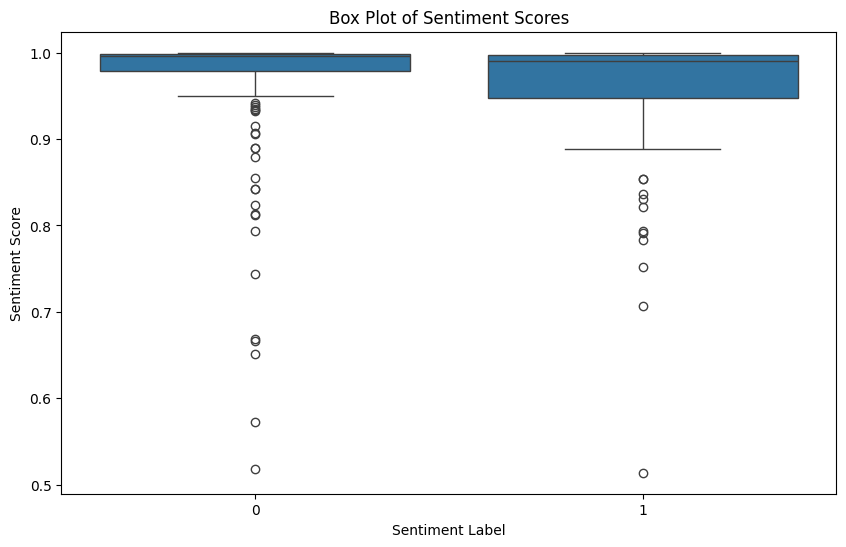

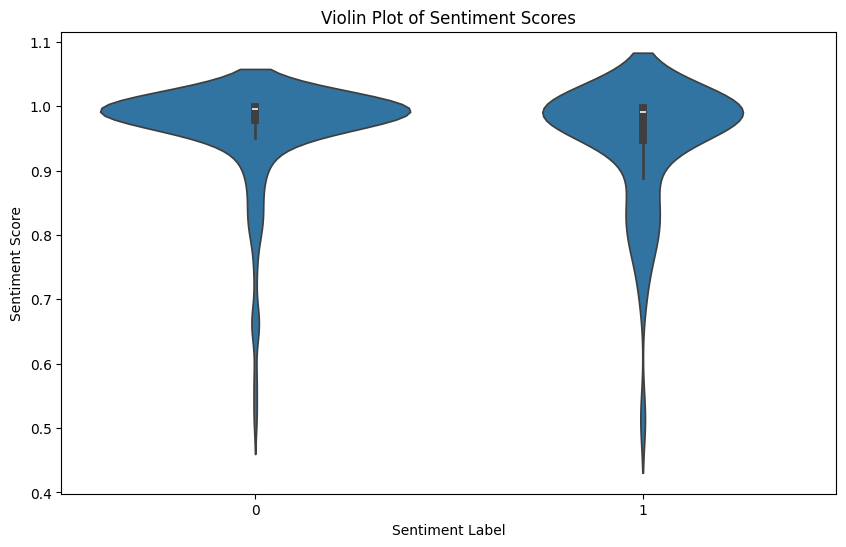

In [226]:
# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment_label', y='sentiment_score', data=sentiment_df)
plt.xlabel('Sentiment Label')
plt.ylabel('Sentiment Score')
plt.title('Box Plot of Sentiment Scores')
plt.show()

# Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='sentiment_label', y='sentiment_score', data=sentiment_df)
plt.xlabel('Sentiment Label')
plt.ylabel('Sentiment Score')
plt.title('Violin Plot of Sentiment Scores')
plt.show()
